![Logo](../assets/logo.png)

Created by: **Domonkos Nagy**

[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/Fortuz/rl_education/blob/main/6.%20n-step%20TD/taxi_solution.ipynb)

# Taxi (solution)

The Taxi Problem involves navigating to passengers in a grid world, picking them up and dropping them off at one of four locations.

<img src="assets/taxi.gif" width="500"/>

There are four designated pick-up and drop-off locations (Red, Green, Yellow and Blue) in the 5x5 grid world. The taxi starts off at a random square and the passenger at one of the designated locations.
The goal is move the taxi to the passenger’s location, pick up the passenger, move to the passenger’s desired destination, and drop off the passenger. Once the passenger is dropped off, the episode ends.

There are 6 possible actions: movement in any of the 4 directions (up, down, right, left) and picking up and dropping off the passenger. The problem has 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.

The rewards are:

- -1 per step unless other reward is triggered,

- +20 for delivering passenger,

- -10 for executing “pickup” and “drop-off” actions illegally.

This notebook uses the *$n$-step tree backup algorithm* to approximate the optimal policy in the `Taxi-v3` Gymnasium environment.

- This notebook is based on Chapter 7 of the book *Reinforcement Learning: An Introduction (2nd ed.)* by R. Sutton & A. Barto, available at http://incompleteideas.net/book/the-book-2nd.html
- Documentation for the Taxi environment: https://gymnasium.farama.org/environments/toy_text/taxi/

In [1]:
# Install dependencies if running in Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install gymnasium==0.29.0

In [2]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import numpy as np
import pickle
from tqdm.notebook import trange, tqdm
from IPython import display
import matplotlib.pyplot as plt
import time
import math
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Hyperparameters
N_EPISODES = 10_000  # Number of training episodes
MAX_STEPS_PER_EPISODE = 200  # Number of steps before truncation (there is no truncation in this env by default)
N_STEPS = 2  # Number of steps to sample from
EPSILON_MAX = 1  # Initial exploration
EPSILON_MIN = 0.1  # Final exploration
EPSILON_DECAY = 2 * EPSILON_MAX / N_EPISODES  # Exploration decay rate
ALPHA = 0.4  # Learning rate
GAMMA = 1  # Discount factor
N_RECORDINGS = 3  # Number of episodes to record
REC_EPISODES = np.linspace(0, N_EPISODES-1, num=N_RECORDINGS, dtype=int)  # Episodes to record
LOG_FREQ = N_EPISODES / 10  # Progress log frequency

In [4]:
# Create environment
base_env = gym.make('Taxi-v3', render_mode='rgb_array')
# Wrap environment to record videos throughout the learning process 
trigger = lambda ep: ep in REC_EPISODES
env = RecordVideo(base_env, video_folder="./videos", episode_trigger=trigger, disable_logger=True)

In [5]:
# Get Q-table shape
action_space_size = env.action_space.n
observation_space_size = env.observation_space.n
q_table_shape = observation_space_size, action_space_size

In [6]:
# Argmax function that breaks ties randomly
def argmax(arr):
    arr_max = np.max(arr)
    return np.random.choice(np.where(arr == arr_max)[0])

# Epsilon-greedy action selection
def select_action(q_table, epsilon, obs):
    if np.random.rand() > epsilon:
        return argmax(q_table[obs])
    else:
        return env.action_space.sample()

# Convert action-values to state-values
def state_value(q_table, obs):
    return np.max(q_table[obs])

## $n$-step Bootstrapping

$n$-step bootstrapping can be seen as a generalization of MC and TD methods. Both of these methods have the same update rule:

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha\left[G - Q(S_t, A_t)\right]$$

The difference is in $G$, often called the *target* of the update. The target of a MC update at time $t$ is the discounted return
from the state $S_t$ up to the terminal state: $G_t^{(MC)} := R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... + \gamma^{T-t-1} R_{T}$. In the case
of TD learning, the target is $G_t^{(TD)} := R_{t+1} + V(S_{t+1})$. While the MC target consists of only sample rewards from the currently simulated
episode, the TD target only takes 1 sample reward into account, and then it *bootstraps*, which means that it uses the estimate of the next state to update the estimate
of the current one.

$n$-step bootstrapping combines these two ideas together: the target for this update is made up by $n$ sample rewards plus the estimate of the successive state's value:

$$G_{t:t+n} := R_{t+1} + \gamma R_{t+2} + ... + \gamma^{n-1} R_{t+n} + \gamma^n V(S_{t+n})$$

### The $n$-step Tree Backup Algorithm

An off-policy version of $n$-step bootstrapping that does not utilize importance sampling is called the $n$*-step tree backup algorithm*. This algorithm utilizes
a mix of expected updates and sample updates: for all non-selected actions, the estimated values are taken into account (just like an expected update), but for
the selected action, the actual next target is added:

$$G_{t:t+n} := R_{t+1} + \gamma \sum_{a\ne A_{t+1}} \pi(a|S_{t+1})Q(S_{t+1},a) + \gamma \pi(A_{t+1} | S_{t+1}) G_{t+1:t+n} \; (\text{where} \; G_{T-1:t+n} := R_T)$$

The backup diagram for the $n=3$ case provides a nice visual representation of this update rule:

<img src="assets/backup_diagram.png" width="100"/>

*Backup diagram from page 152 of the Sutton & Barto book*

### When $\pi$ is Deterministic

In our case, the target policy $\pi$ is deterministic, so $\pi(a|s)\in\{0,1\}$. This means that the update rule can be simplified:

$$
  G_{t:t+n} :=
    \begin{cases}
      R_{t+1} + \gamma G_{t+1:t+n} & \text{if $\pi(S_{t+1}) = A_{t+1}$}\\
      R_{t+1} + \gamma Q(S_{t+1},\pi(S_{t+1})) & \text{if $\pi(S_{t+1}) \ne A_{t+1}$}
    \end{cases},
$$

where $\pi(s)$ is the action $a$ for which $\pi(a|s) = 1$ in state $s$.

In [7]:
# Training function
def train(alpha=ALPHA, n_steps=N_STEPS,
          n_episodes=N_EPISODES, epsilon_decay=EPSILON_DECAY,
          log=True, record=True):
    
    # Select environment and initalize Q-table
    env = RecordVideo(base_env, video_folder="./videos", episode_trigger=trigger, disable_logger=True) if record else base_env
    q_table = np.zeros(q_table_shape)
    episodes = trange(n_episodes) if log else range(n_episodes)
    sum_rewards = 0
    epsilon = EPSILON_MAX

    # Training loop
    for episode in episodes:
        obs, _ = env.reset()
        done = False
        step = 0

        # Select first action
        action = select_action(q_table, epsilon, obs)

        # Store the trajectory
        obses = [obs]
        actions = [action]
        rewards = [0]

        tau = -n_steps + 1  # The time step for which we update the Q-table
        terminal_step = np.inf

        while tau < terminal_step:
            # If the episode is still running, take next step
            if not done:
                # Take step
                new_obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or step >= MAX_STEPS_PER_EPISODE  # Truncating manually

                # Save trajectory
                obses.append(new_obs)
                rewards.append(reward)

                # Store reward and new state
                sum_rewards += reward
                obs = new_obs

                # Select next action if not done
                if done:
                    terminal_step = step + 1
                else:
                    action = select_action(q_table, epsilon, new_obs)
                    actions.append(action)

            # Update Q-table for the action taken n steps ago
            if tau >= 0:
                target = 0

                # Set the last term of the target
                if step + 1 >= terminal_step:
                    target = rewards[terminal_step] + GAMMA * state_value(q_table, obses[terminal_step])
                else:
                    target = rewards[step + 1] + GAMMA * state_value(q_table, obses[step + 1])

                # Loop back in the trajectory, updating target
                for k in range(min(terminal_step - 1, step), tau, -1):
                    if actions[k] == argmax(q_table[obses[k]]):
                        target = rewards[k] + GAMMA * target
                    else:
                        target = rewards[k] + GAMMA * state_value(q_table, obses[k])

                # Update Q-table
                q_table[obses[tau], actions[tau]] += alpha * \
                    (target - q_table[obses[tau], actions[tau]])

            step += 1
            tau += 1

        # Decay epsilon
        epsilon = max(epsilon - epsilon_decay, EPSILON_MIN)

        # Log results
        if log and (episode + 1) % LOG_FREQ == 0:
            print(f'Episode {episode + 1} : avg={sum_rewards / LOG_FREQ}')
            sum_rewards = 0
            
    # Close environment
    env.close()

    return q_table

In [8]:
# Train
q_table = train()

# Save Q-table
with open('q_table.bin', 'wb') as f:
    pickle.dump(q_table, f)

  0%|          | 0/10000 [00:00<?, ?it/s]

Episode 1000 : avg=-540.238
Episode 2000 : avg=-148.749
Episode 3000 : avg=-49.254
Episode 4000 : avg=-14.317
Episode 5000 : avg=0.765
Episode 6000 : avg=2.14
Episode 7000 : avg=2.377
Episode 8000 : avg=2.158
Episode 9000 : avg=2.424
Episode 10000 : avg=2.842


## Results

You can watch the videos recorded throughout the training process here:

In [9]:
# Display recordings
children = [widgets.Video.from_file(f'./videos/rl-video-episode-{episode}.mp4', autoplay=False, loop=False, width=500) for episode in REC_EPISODES]
tab = widgets.Tab()
tab.children = children
titles = tuple([f'Episode {episode + 1:,}' for episode in REC_EPISODES])
for i in range(len(children)):
    tab.set_title(i, titles[i])
display.display(tab)

## Finding the Optimal $n$

As you might expect, there is no universal best value for $n$, it will always depends on the problem. The method will eventually converge to the optimal policy and value function
regardless of the choice of $n$, but the speed of convergence can vary greatly depending on this choice. The plot below compares different values of $n$ and $\alpha$ at different levels
of training.

**Note**: The process below can take a long time to finish, as it involves repeating the training process many times with different parameters.

In [10]:
# Play n_episodes episodes using a greedy policy w.r.t. the argument Q-table,
# and return the average reward
def test(q_table, n_episodes=N_EPISODES):
    sum_reward = 0

    for episode in range(n_episodes):
        obs, _ = base_env.reset()
        done = False
        step = 0

        while not done:
            # Select action (greedy)
            action = argmax(q_table[obs])

            # Take step
            new_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or step >= MAX_STEPS_PER_EPISODE  # Truncating manually

            # Store reward and new state
            sum_reward += reward
            obs = new_obs
            step += 1

    return sum_reward / n_episodes

In [11]:
# Hyperparameters to compare
episode_counts = [100, 500, 1000, 5000]
step_counts = [1, 2, 4]
alphas = np.linspace(0.1, 1, 4)
n_trials = 5

# Compare parameters
comparison_results = np.zeros((len(episode_counts), len(step_counts), len(alphas)))
for t in range(n_trials):
    display.clear_output(wait=True)
    print(f'Trial {t+1}/{n_trials}')

    # For all episode counts
    for i, n_episodes in enumerate(tqdm(episode_counts)):
        # For all values of n
        for j, n_steps in enumerate(tqdm(step_counts)):
            # For all values of alpha
            for k, alpha in enumerate(alphas):
                # Train
                epsilon_decay = 2 * EPSILON_MAX / n_episodes
                q_table = train(alpha=alpha, n_steps=n_steps,
                                n_episodes=n_episodes, epsilon_decay=epsilon_decay,
                                log=False, record=False)

                # Test
                comparison_results[i, j, k] += test(q_table, 100)

# Average performance over n_trials
comparison_results = comparison_results / n_trials

# Save results
with open('comparison_results.bin', 'wb') as f:
    pickle.dump(comparison_results, f)

Trial 5/5


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

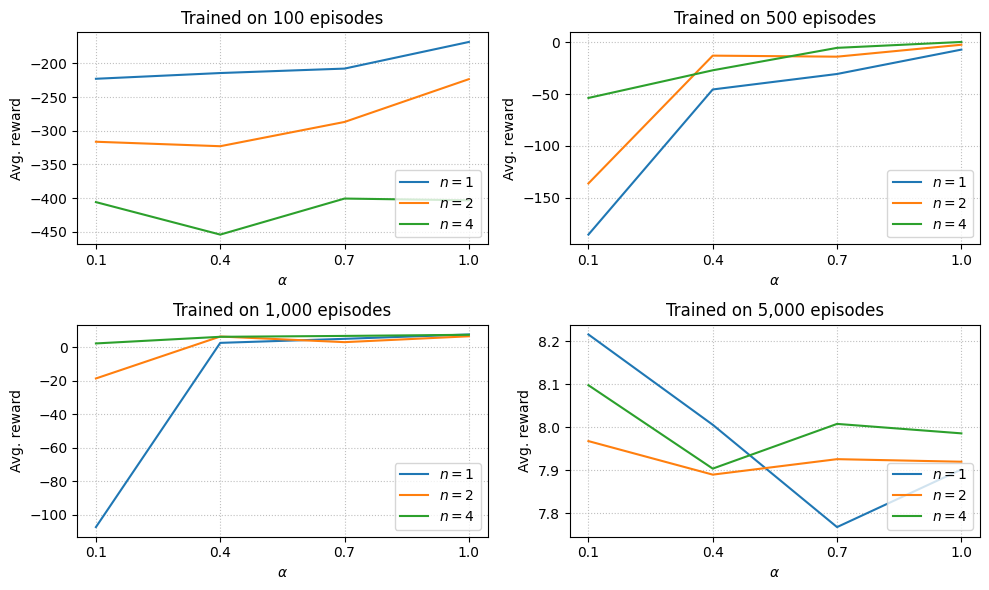

In [12]:
# Load results
with open('comparison_results.bin', 'rb') as f:
    comparison_results = pickle.load(f)

# Set up plot
nrows = math.ceil(len(step_counts) / 2)
fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(10, 3*nrows))
axs = axs.flatten()

# Plot results
for i, n_episodes in enumerate(episode_counts):
    ax = axs[i]
    ax.set_title(f'Trained on {n_episodes:,} episodes')

    for j, n_steps in enumerate(step_counts):
        ax.plot(alphas, comparison_results[i, j, :], label=f'$n={n_steps}$',
                zorder=2)

    ax.legend(loc='lower right')
    ax.set_ylabel('Avg. reward')
    ax.set_xlabel('$\\alpha$')
    ax.set_xticks(alphas)
    ax.grid(alpha=0.8, linestyle=':', zorder=0)

plt.tight_layout()
plt.show()